In [218]:
import glob
from ctapipe.io import read_table
from astropy.table import vstack, Table
from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
from lstchain.io.io import dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_tel_mon_flat_key
import matplotlib.pyplot as plt
import numpy as np

from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import EngineeringCameraFrame
from ctapipe.instrument import SubarrayDescription
from ctapipe.containers import EventType

%matplotlib inline

In [236]:
# File to explore:
dl1_file = "/fefs/aswg/data/real/DL1/20201120/v0.8.2.post1/tailcut84/dl1_LST-1.Run02973.0010.h5"

In [237]:
# Read useful configuration information:
subarray_info = SubarrayDescription.from_hdf(dl1_file)
print(subarray_info.tels)
# Obtain camera geometry:
camgeom = subarray_info.tel[1].camera.geometry
# Transform camera geometry to the more usual "engineering camera frame":
camgeom = camgeom.transform_to(EngineeringCameraFrame())
camgeom

{1: TelescopeDescription(type=LST, name=LST, optics=LST, camera=LSTCam)}


CameraGeometry(camera_name='LSTCam', pix_type=<PixelShape.HEXAGON: 'hexagon'>, npix=1855, cam_rot=-1.5707963267948966 rad, pix_rot=-3.3317113690095352 rad)

In [238]:
# Where the image parameters (DL1b) are stored in the hdf5 files:
print(dl1_params_lstcam_key)

/dl1/event/telescope/parameters/LST_LSTCam


In [239]:
# Read parameters table from file:
dl1_parameters = read_table(dl1_file, dl1_params_lstcam_key)

In [240]:
# Check column names:
print(dl1_parameters.columns)

<TableColumns names=('obs_id','event_id','intensity','log_intensity','x','y','r','phi','length','length_uncertainty','width','width_uncertainty','psi','skewness','kurtosis','time_gradient','intercept','leakage_intensity_width_1','leakage_intensity_width_2','leakage_pixels_width_1','leakage_pixels_width_2','n_pixels','concentration_cog','concentration_core','concentration_pixel','n_islands','alt_tel','az_tel','calibration_id','dragon_time','ucts_time','tib_time','ucts_jump','mc_type','wl','tel_id','tel_pos_x','tel_pos_y','tel_pos_z','trigger_type','ucts_trigger_type','trigger_time','event_type')>


Description of parameters in\
https://github.com/cta-observatory/cta-lstchain/blob/master/lstchain/io/lstcontainers.py

Notes: 
- these DL1 files are provisional and LST-specific. Eventually we will use the agreed DL1 model already implemented in ctapipe:\
    https://cta-observatory.github.io/ctapipe/data_models/dl1.html#dl1-data-model


- there are some parameters which do not change event-wise, yet they are written in the events table for convenience (tel_id, tel_pos_x, y, z)

- Note: some parameters don't have their units in the table (if not mentioned below, they are adimensional):
 - timestamps, like dragontime (currently the most reliable one) are in seconds (unix timestamps)


In [241]:
dl1_parameters

obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,calibration_id,dragon_time,ucts_time,tib_time,ucts_jump,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
,,,,m,m,m,rad,deg,deg,deg,deg,rad,,,,,,,,,,,,,,rad,rad,,,,,,,,,m,m,m,,,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,float64,float64,int64,float64,int64,int64,bool,int64,float64,int64,float64,float64,float64,uint8,uint8,float64,int64
2973,530001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1,nan,nan,nan,-1,1.4496387125656705,2.773765981526981,0,1605926144.32013,0,0,False,-9999,nan,1,50.0,50.0,16.0,1,1,1605926144.32013,32
2973,530002,266.37029933929443,2.4254857987559753,-0.33783384085091817,0.25345289387428166,0.42233881355770675,2.497944718156128,0.15826966251742186,0.004955541035636826,0.08146035782163548,0.003850042976368914,-1.0220378006460005,0.18777392561975448,2.044552767251951,-0.6653095222625414,13.620397528433749,0.0,0.0,0.0,0.0,18,0.2807041763988961,0.4964538281391736,0.1431762527607233,1,1.4496387154805832,2.773766226379676,0,1605926144.3205755,0,0,False,-9999,0.514692482564721,1,50.0,50.0,16.0,1,1,1605926144.3205755,32
2973,530003,122.21522235870361,2.087125302262166,-0.023873303626152028,-0.8123286674785423,0.812679394739088,-1.6001765949546103,0.09303097381607586,0.0052717844792967055,0.060757138407274244,0.003635608446766449,1.3394941447844815,0.17658939063096907,2.569801331030676,-11.190017856156553,14.663508526797958,0.0,0.0,0.0,0.0,11,0.45005320988134173,0.26695622085310616,0.26695622085310616,1,1.4496387174654706,2.773766393110205,0,1605926144.3208787,0,0,False,-9999,0.653084723239027,1,50.0,50.0,16.0,1,1,1605926144.3208787,32
2973,530004,191.67175340652466,2.2825581157807693,0.14758452650699783,0.23989230896821812,0.2816549526750733,1.0192668600795334,0.0889251495357053,0.0041852772960526636,0.050889419824241604,0.0025104758965545323,1.5482926866272277,0.4979008193184659,2.69830887027727,0.7819151484992264,15.039498001342102,0.0,0.0,0.0,0.0,9,0.6881548217949561,0.28109527928541184,0.28109527928541184,1,1.4496387176433614,2.773766408053036,0,1605926144.320906,0,0,False,-9999,0.5722722155730221,1,50.0,50.0,16.0,1,1,1605926144.320906,32
2973,530005,162.09044551849365,2.2097574159534568,0.31124086510083676,-0.5872293202525073,0.6646120301897483,-1.0834253496182884,0.34371899234260866,0.032886063022104506,0.05305117253832632,0.002515223068447393,-1.4501145703604958,2.3766603936321085,6.935041943226261,9.908579859781929,13.231468552916752,0.10849952,0.10849952,0.001078167115902965,0.001078167115902965,9,0.2944785691895699,0.6412105103269689,0.27349470889305355,2,1.4496387189104436,2.7737665144879333,0,1605926144.3210995,0,0,False,-9999,0.15434279883075527,1,50.0,50.0,16.0,1,1,1605926144.3210995,32
2973,530006,187.25928020477295,2.272443349692488,0.375884416191961,-0.8964730438800071,0.9720869368217313,-1.173769905406557,0.20187540646318167,0.015456359713630515,0.0920915464724137,0.004044898827091733,-0.5967453917581487,-1.6134253073087563,5.390837579403152,-11.121557964814901,13.146674555132977,0.0,0.14298521,0.0,0.00215633423180593,17,0.3239396086040577,0.470117511858728,0.1968379132497004,2,1.4496387201759653,2.773766620791753,0,1605926144.3212929,0,0,False,-9999,0.4561786217816835,1,50.0,50.0,16.0,1,1,1605926144.3212929,32
2973,530007,49.15516424179077,1.6915691515454574,-0.872693708281442,0.005264259349663807,0.872709585658663,3.135560530921527,0.07442714417858935,0.007775268235063199,0.03923598886143509,0.0021338141388819003,-0.0031573790

## Read images table from file:

In [242]:
dl1_images = read_table(dl1_file, dl1_images_lstcam_key)
print(dl1_images.columns)

<TableColumns names=('obs_id','event_id','image','peak_time','image_mask','tel_id','selected_gain_channel')>


## Plot a bright image:

In [262]:
import astropy.units as u
# Locate first table entry for which n_pixels (after cleaning) is larger than 100, and is a cosmic:
mask = ((dl1_parameters['n_pixels']>100) & 
        (dl1_parameters['r']<0.5*u.m) &
        (dl1_parameters['event_type']==EventType.SUBARRAY.value)
       )
index = np.where(mask)[0][0]

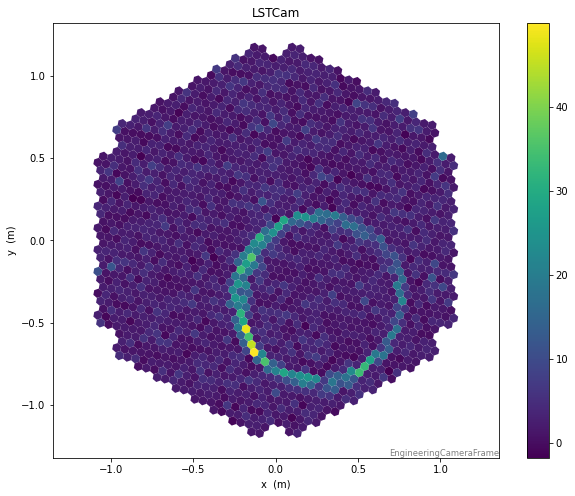

In [263]:
plt.figure(figsize=(10,8))
camdisplay = CameraDisplay(camgeom, dl1_images['image'][index])
camdisplay.add_colorbar()
plt.show()

## Read calibration monitoring tables from file:

In [245]:
monitor_ped = read_table(dl1_file, dl1_params_tel_mon_ped_key)
monitor_cal = read_table(dl1_file, dl1_params_tel_mon_cal_key)

In [246]:
monitor_ped

tel_id,calibration_id,pedestal_id,flatfield_id,n_events,sample_time,sample_time_min,sample_time_max,"charge_mean [2,1855]","charge_median [2,1855]","charge_std [2,1855]","charge_median_outliers [2,1855]","charge_std_outliers [2,1855]"
,,,,,s,s,s,,,,,
int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,bool,bool
1,0,0,0,10000,5.855929398146387e-05,1605914727.886898,1605914738.005944,-0.6167152492240071 .. 1.82128215636611,-16.498023986816406 .. 1.6406139731407166,215.4279449423478 .. 22.085835322441405,False .. False,False .. False
1,1,1,1,871,5.28377615740816e-05,1605926181.3222246,1605926190.4525898,-2.9524346074061607 .. 3.1640928786774043,-26.673017501831055 .. 1.9265425205230713,195.6718221799063 .. 22.783595871118507,False .. False,False .. False


In [247]:
monitor_cal

tel_id,calibration_id,pedestal_id,flatfield_id,time,time_min,time_max,"dc_to_pe [2,1855]","pedestal_per_sample [2,1855]","time_correction [2,1855]","n_pe [2,1855]","unusable_pixels [2,1855]"
,,,,s,s,s,,,ns,,
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,bool
1,0,0,0,5.8749781249978206e-05,1605914727.8863301,1605914738.0382924,0.012424848962207658 .. 0.21939704550164338,-1.3748353322347004 .. 0.13671783109505972,-1.0414247512817383 .. 0.31426048278808594,89.26865640692802 .. 75.42959411381048,False .. False
1,1,1,1,5.2790839699085046e-05,1605926181.3277853,1605926190.4500422,0.011859135262834266 .. 0.20330949961748299,-2.2227514584859214 .. 0.16054521004358926,0.11667442321777344 .. 0.14360427856445312,88.11610655715077 .. 66.59713222676693,False .. False


In the monitoring tables above, calibration_id = 0 indicates the values were obtained from the dedicated calibration (flatfield + pedestal) run taken before observation, while calibration_id > 0 corresponds to values obtained with the interleaved pedestal and flafield events.

In the parameters table, calibration_id (currently always = 0) indicates which calibration constants are used to calibrate the events (currently, always those from the dedicated calibration run)

The 2D arrays in the monitoring tables are all Ngains * Npixels, with Ngains always = 2 (high and low gain)

## Display the standard deviation of pixel charge (in photoelectrons) calculated from interleaved pedestals:

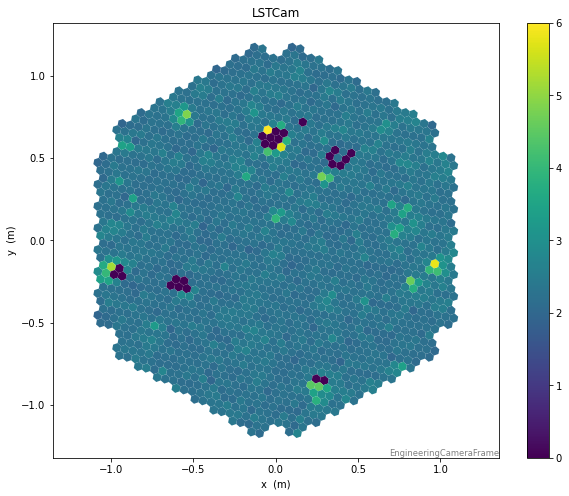

In [266]:
# The 1 index below means 'interleaved', while the 0 index selects the high-gain values:

hg_stdev_counts = monitor_ped['charge_std'][1][0]
hg_counts_to_pe = monitor_cal['dc_to_pe'][1][0]

plt.figure(figsize=(10,8))
camdisp = CameraDisplay(camgeom, hg_stdev_counts*hg_counts_to_pe)
camdisp.add_colorbar()
plt.show()

The "hot" and "cold" pixels in the display above are mostly due to stars, which make pixels noisy, and eventually may turn them off.

In the application of the DL1a to DL1b step to real data, the monitoring pedestal info for the high gain, as determined from the interleaved pedestal events within a subrun, is used to apply the "pedestal cleaning". The core pixel threshold is raised to 2.5 times the standard deviation above the mean charge, if that turns out to be larger than the standard "base" picture threshold (8 p.e.). 

This cleaning, which aims at reducing the effect of noise from stars, is the reason why for the real data the step DL1a to DL1b has to be done after the R0 to DL1 stage, because only after the latter is the needed information from the interleaved events available. In MC we do not have stars or real data, so the  cleaning can be done straightaway in the R0 to DL1 stage. This is of course one of the possible sources of disagreement between data and MC, and the base cleaning (picture: 8 p.e., boundary: 4 p.e.) was chosen such that not too many pixels get increased cleaning thresholds because of stars.

Below we can see the effect of stars in the distribution of the centers of gravity of shower images:

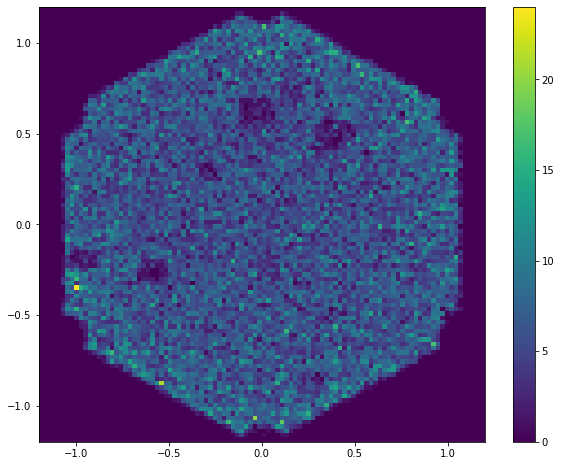

In [269]:
plt.figure(figsize=(10, 8))
cosmics_mask = dl1_parameters['event_type']==32

# Note: coordinates of the image center of gravity, (x,y), are in the ctapipe.coordinates.CameraFrame 
# (different from the EngineeringCameraFrame displayed above). Small hack: relation between the two systems
# is just x => -y;  y => -x:

plt.hist2d(-dl1_parameters['y'][cosmics_mask], 
           -dl1_parameters['x'][cosmics_mask], 
           bins=(100,100), range=((-1.2, 1.2),(-1.2, 1.2)))
plt.colorbar()
plt.show()